In [1]:
### Compare AVISO tidal current against observed 2023 SD-1042's band-pass semidiurnal tidal current
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pyfes ### has to use newpycode
import os
import sys
from scipy.stats import pearsonr
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from mystats import bandpass_sos

In [2]:
### SD-1042 merged nc file info
year = '2023'
platf_num = '1042'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'

### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
print(ds_adcp)
time = ds_adcp.variables['time'][:];
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
timestamp_SD = np.array([dtime_cur_SD[i].timestamp() for i in range(len(dtime_cur_SD))])
lon = ds_adcp.variables['longitude'][:];
lat = ds_adcp.variables['latitude'][:];
uCur_SD = ds_adcp.variables['vel_east'][:]*100; # cm/s
vCur_SD = ds_adcp.variables['vel_north'][:]*100;
depths_cur_SD = ds_adcp.variables['depth'][:]; # the shallowest depth should be ~6m. 
dz_add = 6-depths_cur_SD[0]
depths_cur_SD = depths_cur_SD+dz_add
print(depths_cur_SD)
data_flag = ds_adcp.variables['data_flag'][:]
uCur_SD[data_flag> 0] = np.nan
vCur_SD[data_flag> 0] = np.nan

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1042
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(6154), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time,depth), float64 vel_north(time,depth), float64 vel_up(time,depth), float64 error_vel(time,depth), float64 percent_good_4_beam(time,depth), float64 percent_good_3_beam(time,depth), float64 percent_good(time,depth), float64 bt_range(time,beam), float64 bt_cor(time,beam), float64 bt_amp(time,beam), float64 bt_percent_good(time,b

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_35682/3013076598.py:8: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(ds_adcp)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_35682/3013076598.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time = ds_adcp.variables['time'][:];
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_35682/3013076598.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated i

In [3]:
### time limit and time ticklabels
tlim_plot = [datetime.datetime(int(year),10,19,12), datetime.datetime(int(year),11,15,23)] ### 2023 SD1042
nday_plot = (tlim_plot[1]-tlim_plot[0]).days+1
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

<Figure size 432x288 with 0 Axes>

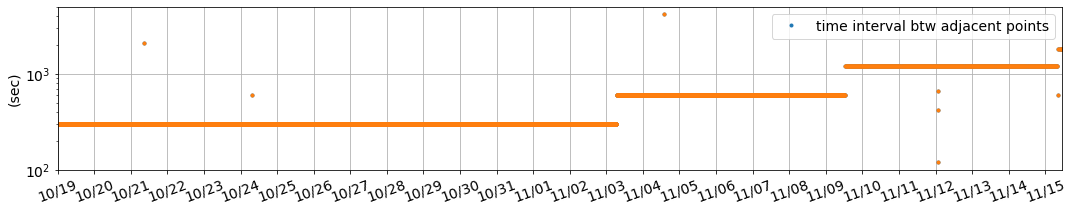

In [4]:
### plot time intervals
nrow = 1
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrow,1, figsize=(18, 3))
plt.subplot(nrow,1,1)
plt.semilogy(dtime_cur_SD[:-1],np.diff(np.sort(timestamp_SD)),'.',label='time interval btw adjacent points')
plt.semilogy(dtime_cur_SD[:-1],np.diff(timestamp_SD),'.')
plt.ylabel('(sec)'); plt.legend()
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=20)
    plt.xlim(tlim_plot)
    plt.grid()

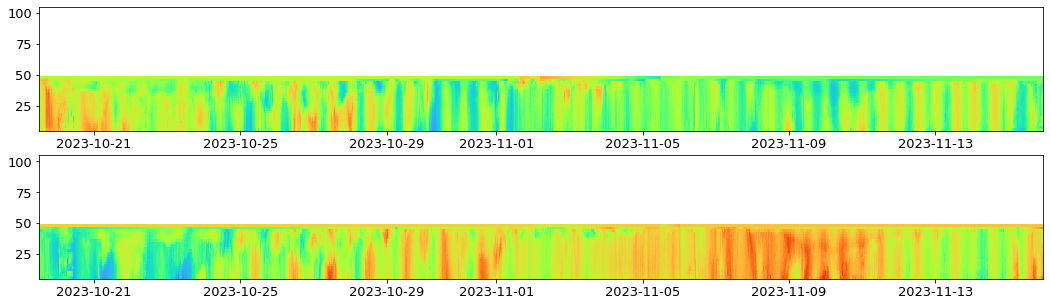

In [5]:
### linear interpolate data in time
dsec = 1200 # seconds
nt_grid = int( (tlim_plot[1]-tlim_plot[0]).total_seconds()/dsec )
dtime_grid = np.array([tlim_plot[0]+datetime.timedelta(seconds=i*dsec) for i in range(nt_grid)])
timestamp_grid = np.array([dtime_grid[i].timestamp() for i in range( len(dtime_grid) )])

uCur_grid = np.nan*np.ones( (len(dtime_grid), len(depths_cur_SD)) )
vCur_grid = uCur_grid.copy()
lon_grid = np.nan*np.ones( (len(dtime_grid),) )
lat_grid = lon_grid.copy()
for z in range( len(depths_cur_SD) ):
    isOK = ~np.isnan( uCur_SD[:,z] )
    if np.sum(isOK) > 2:
        uCur_grid[:,z] = np.interp( timestamp_grid, timestamp_SD[isOK], uCur_SD[isOK,z] )
        vCur_grid[:,z] = np.interp( timestamp_grid, timestamp_SD[isOK], vCur_SD[isOK,z] )
    isOK = ~np.isnan( lon )
    if z == 0:
        lon_grid = np.interp( timestamp_grid, timestamp_SD[isOK], lon[isOK] )
        lat_grid = np.interp( timestamp_grid, timestamp_SD[isOK], lat[isOK] )

### plot
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
plt.subplot(2,1,1)
plt.pcolormesh( dtime_grid, depths_cur_SD, uCur_grid.transpose(), vmin=-50, vmax=50, cmap='turbo')
plt.subplot(2,1,2)
plt.pcolormesh( dtime_grid, depths_cur_SD, vCur_grid.transpose(), vmin=-50, vmax=50, cmap='turbo')

In [6]:
### Use pyfes tool box to build the tide model
path_aviso = os.path.expanduser('~/Documents/Data/AVISO/auxiliary/tide_model/fes2014/')
ConfigFileU = path_aviso+'eastward_velocity.ini'
ConfigFileV = path_aviso+'/northward_velocity.ini'
eastward_velocity = pyfes.Handler("ocean","memory",ConfigFileU)
northward_velocity = pyfes.Handler("ocean", "memory",ConfigFileV)

### 
u_AVISO_tide = np.nan*np.ones( dtime_grid.shape )
v_AVISO_tide = u_AVISO_tide.copy()
for i in range( len(dtime_grid) ):
    u_AVISO_tide[i],_,_ = eastward_velocity.calculate(np.array([lon_grid[i]]),np.array([lat_grid[i]]),np.array([dtime_grid[i]]))
    v_AVISO_tide[i],_,_ = northward_velocity.calculate(np.array([lon_grid[i]]),np.array([lat_grid[i]]),np.array([dtime_grid[i]]))

The mean latitude of SD between 2023/10/19 12Z-11/15 23Z = 27.49N


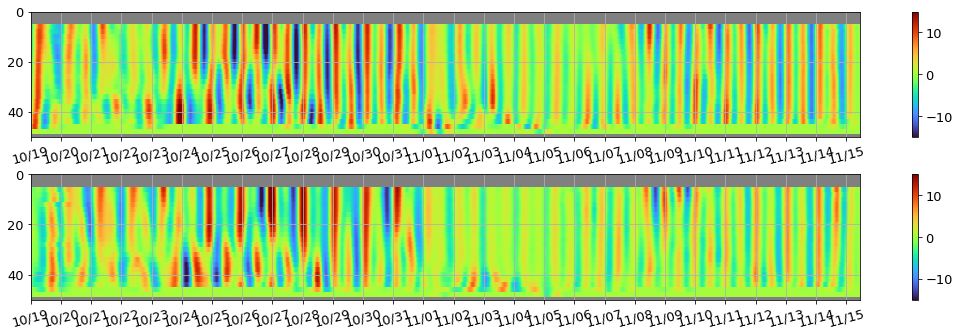

In [7]:
### bandpass the SD current velocity
itlim_plot = np.where( (dtime_grid>= tlim_plot[0]) & (dtime_grid<= tlim_plot[1]) )[0]
lat_mn = np.nanmean( lat[itlim_plot] )
print('The mean latitude of SD between '+tlim_plot[0].strftime('%Y/%m/%d %HZ-')+tlim_plot[1].strftime('%m/%d %HZ')+' = {:.2f}N'.format(lat_mn))
f_mn = 2*(2*np.pi/86400)*np.sin(lat_mn/180*np.pi) # 1/s
n_f = np.array([0.8,2.5])
f_bp = f_mn*n_f
bp_sec = 2*np.pi/f_bp
###
uCur_bp = np.nan*np.ones( uCur_grid.shape )
vCur_bp = uCur_bp.copy()
for z in range( len(depths_cur_SD) ):
    isOK = ~np.isnan( uCur_grid[:,z] )
    # print(np.sum(isOK),len(isOK))
    if np.sum(isOK) > 2:
        uCur_bp[isOK,z] = bandpass_sos(uCur_grid[isOK,z],dsec,bp_sec[0],bp_sec[1],2)
        vCur_bp[isOK,z] = bandpass_sos(vCur_grid[isOK,z],dsec,bp_sec[0],bp_sec[1],2)

### plot SD bandpass filtered veloicities
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
plt.subplot(2,1,1)
plt.pcolormesh( dtime_grid, depths_cur_SD, uCur_bp.transpose(), vmin=-15, vmax=15, cmap='turbo')
plt.subplot(2,1,2)
plt.pcolormesh( dtime_grid, depths_cur_SD, vCur_bp.transpose(), vmin=-15, vmax=15, cmap='turbo')
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.xlim(tlim_plot)
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=15)
    plt.grid()
    plt.gca().set_facecolor('gray')
    plt.colorbar()
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.3)

R = 0.918
R = 0.725


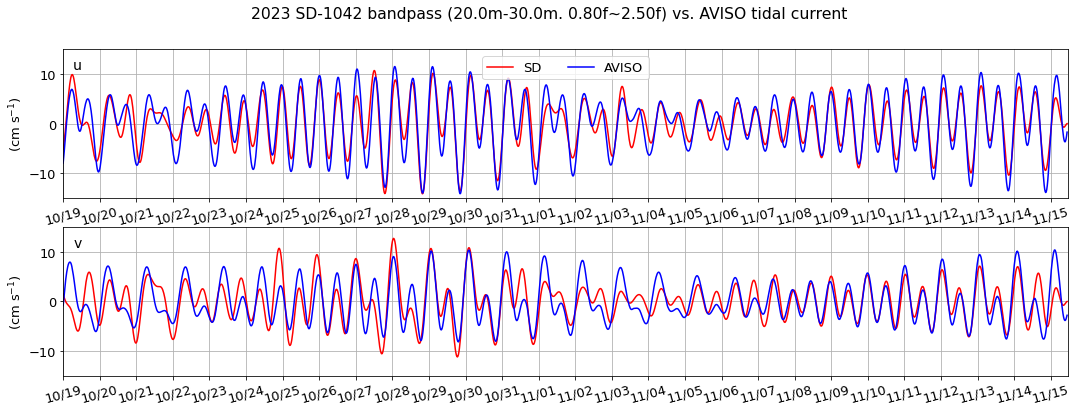

In [20]:
### plot time series
vars_SD = ['uCur_bp','vCur_bp']
vars_AVISO = ['u_AVISO_tide','v_AVISO_tide']
vars_str_title = ['u','v']
izSD = np.where( (depths_cur_SD>= 20) & (depths_cur_SD<= 30) )[0] # depths_cur_SD== 6
nrow = len(vars_SD)
plt.clf()
plt.gcf().set_size_inches(18, 6)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    ySD = np.nanmean(eval(vars_SD[i])[:,izSD],axis=1)
    plt.plot( dtime_grid, ySD,color='red',label='SD' )
    plt.plot( dtime_grid, eval(vars_AVISO[i]),color='blue',label='AVISO' )
    r = pearsonr(ySD, eval(vars_AVISO[i]))
    print('R = {:.3f}'.format(r[0]))
    ###
    plt.xlim(tlim_plot)
    plt.ylim([-15,15])
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=15)
    plt.grid()
    plt.gca().text(0.01,0.85,vars_str_title[i],ha='left',va='bottom',transform=plt.gca().transAxes,fontsize=14)
    plt.ylabel('(cm s$^{-1}$)')
    if i == 0:
        plt.legend(loc='upper center',ncol=2)
plt.suptitle(year+' SD-'+platf_num+' bandpass ({:.1f}m-{:.1f}m. {:.2f}f~{:.2f}f) vs. AVISO tidal current'\
             .format(depths_cur_SD[izSD][0],depths_cur_SD[izSD][-1],n_f[0],n_f[1]))
###
plt.savefig('timeseries_uv_'+year+'-SD'+platf_num+'({:.1f}m-{:.1f}m_bp{:.2f}f-{:.2f}f)_AVISO_fes2014_'\
            .format(depths_cur_SD[izSD][0],depths_cur_SD[izSD][-1],n_f[0],n_f[1])+\
                tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

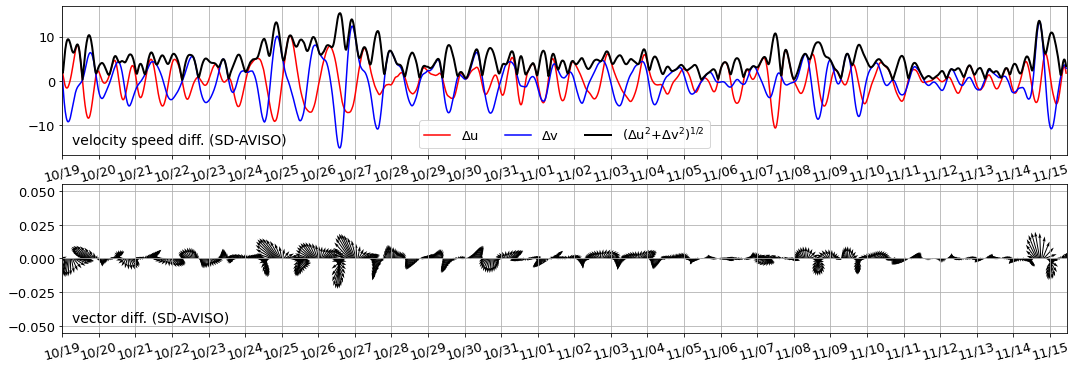

In [19]:
### plot band pass velocity(SD) - tidal velocity(AVISO)
vars_str_title = ['velocity speed diff. (SD-AVISO)','vector diff. (SD-AVISO)']
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 6)
plt.rcParams.update({'font.size': 13})
# difference in u & v
vars_SD = ['uCur_bp','vCur_bp']
vars_AVISO = ['u_AVISO_tide','v_AVISO_tide']
cols = ['red','blue']
dvel = np.nan*np.ones( (len(dtime_grid),2) )
plt.subplot(nrow,1,1)
for i in range( len(vars_SD) ):
    dvel[:,i] = np.nanmean(eval(vars_SD[i])[:,izSD],axis=1)- eval(vars_AVISO[i])
    plt.plot( dtime_grid, dvel[:,i], color=cols[i],label='$\Delta$'+vars_SD[i][0])
y = np.sqrt( np.square(dvel[:,0])+ np.square(dvel[:,1]) )
plt.plot( dtime_grid, y, color='k',lw=2, label='($\Delta$u$^2$+$\Delta$v$^2$)$^{1/2}$')
plt.legend(loc='best',ncol=3)
###
plt.subplot(nrow,1,2)
plt.quiver(dtime_grid[::2],np.zeros(dtime_grid[::2].shape),dvel[::2,0],dvel[::2,1],scale=500,width=0.001)
### 
for i in range(2):
    plt.subplot(nrow,1,i+1)
    plt.xlim(tlim_plot)
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label,rotation=15)
    plt.grid()
    plt.gca().text(0.01,0.05,vars_str_title[i],ha='left',va='bottom',transform=plt.gca().transAxes,fontsize=14)
### 
plt.savefig('timeseries_dudv(SD-AVISO)_'+year+'-SD'+platf_num+'({:.1f}m-{:.1f}m_bp{:.2f}f-{:.2f}f)_AVISO_fes2014_'\
            .format(depths_cur_SD[izSD][0],depths_cur_SD[izSD][-1],n_f[0],n_f[1])+\
                tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')